Approximate an estimator of a function of a high-fidelity nonlinear model by applying nested multifidelity ACVs - which look suspiciously like group ACVs. The first level partitions the original function and learns control weights for the same. (variance reduction for full gradient - which is an expectation over $n$ particles)

The (optional) second level separates the expectation terms related to the high-fidelity nonlinear model and decomposes them to yield another ACV that uses the low-fidelity models. (variance reduction for expectation of likelihood)

This is useful for accelerating particle-based inference and downstream optimization tasks that require posterior approximation. Using only the inner nested level does not decompose the kernel gradient correctly while using only the outer level brings less speedups on account of still retaining a significant chunk of the high-fidelity model evaluations. (All of this really depends on how we define the multifidelityness of the original function i.e. only in terms of the likelihood or considering both kernel and likelihood).

_Unknowns_:

- does this work? shouldn't particles for lower-fidelity likelihoods simply diverge farther away from high-fidelity estimate of posterior?

- gradients are 2D for toy problem and many many D for a real one. Is there some average QoI we can target? e.g. magnitude of particle velocity or reframe the problem? 

- are kernel evaluations now restricted to smaller subsets of particles? (interactions between levels forbidden or not?)

- can a common kernel function serve us well in terms of expressiveness? A truly nested ACV would be one where we change the neighbourhood size for each particle on one level and assign particles on another.

- Does the multifidelity allocation step get repeated at every iteration if the covariances are not between log-lik-gradients and we use an estimate of the covariances between Stein gradients instead?

- restrictive for model form? could we make this work for implicit likelihoods?

- can OED (in general) select points for training multiple models or not? - LATER, but very promising - it would make for a good paper.


In [90]:
import os
import re
import numpy as np
import torch
import scipy
from scipy.spatial.distance import pdist, squareform
from scipy.stats import multivariate_normal
from scipy.stats import qmc
import numpy.matlib as nm

from mxmc import Optimizer

from rich.progress import track

In [91]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("axes.spines", right=True, top=True)
plt.rc("figure",
      #  dpi=150,
      #  figsize=(9, 3)
      )
plt.rc("font", family="serif")
plt.rc("legend", edgecolor="none", frameon=True)
plt.style.use("dark_background")

marker_symbol = u'\u2B2C'

In [92]:
sampler = qmc.Sobol(d=2, scramble=False)
initial_particles = sampler.random(n=512)

# rescale initial points to lie within -1, 1
initial_particles = 2 * initial_particles - 1

In [93]:
costs = np.array([1, 0.25])

In [94]:
mu_oracle_hf = np.array([0.5, 0.2])
cov_oracle_hf = np.array([[2.0, 0.3], [0.3, 0.5]])

mu_oracle_lf = np.array([0.8, 0.32])
cov_oracle_lf = np.array([[1.5, 0.35], [0.35, 0.5]])

In [95]:
# obviously same defns for toy experiment (two Gaussians)
def mvn_dlnprob_hf(theta, mu, cov):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))

def mvn_dlnprob_lf(theta, mu, cov):
    return -1*np.matmul(theta-nm.repmat(mu, theta.shape[0], 1),
                        np.linalg.inv(cov))

In [96]:
class RBF(torch.nn.Module):
    def __init__(self, sigma=None):
        super(RBF, self).__init__()

        self.sigma = sigma

    def forward(self, X, Y):
        XX = X.matmul(X.t())
        XY = X.matmul(Y.t())
        YY = Y.matmul(Y.t())

        dnorm2 = -2 * XY + XX.diag().unsqueeze(1) + YY.diag().unsqueeze(0)

        # Apply the median heuristic (PyTorch does not give true median)
        if self.sigma is None:
            np_dnorm2 = dnorm2.detach().cpu().numpy()
            h = np.median(np_dnorm2) / (2 * np.log(X.size(0) + 1))
            sigma = np.sqrt(h).item()
        else:
            sigma = self.sigma

        gamma = 1.0 / (1e-8 + 2 * sigma ** 2)
        K_XY = (-gamma * dnorm2).exp()

        return K_XY

# Let us initialize a reusable instance right away.
K = RBF()

In [102]:
class SVGD_ll():
    """
    Low-level SVGD implementation from DartML
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy, h)


    def update(self, x0, lnprob,
               mu,
               cov,
               n_iter = 1000,
               stepsize = 1e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta_all = np.zeros((x0.shape[0], x0.shape[1], n_iter))
        lengthscales_all = np.zeros(n_iter)
        theta = np.copy(x0)
        lnpgrad_inter = np.zeros((x0.shape[0], x0.shape[1], n_iter))
        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        kxy_final = []
        dxkxy_final = []
        lnpgrad_final = []
        adj_grads = []
        for iter in track(range(n_iter), description="Running iterations for particle position updates..."):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1))

            lnpgrad = lnprob(theta, mu, cov)
            lnpgrad_inter[:, :, iter] = lnpgrad
            # calculating the kernel matrix
            kxy, dxkxy, h = self.svgd_kernel(theta, h=-1)
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]

            lengthscales_all[iter] = h

            # adagrad
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad

            adj_grads.append(adj_grad)
            theta_all[:, :, iter] = theta
            if iter == n_iter - 1:
                kxy_final = kxy
                dxkxy_final = dxkxy
                lnpgrad_final = lnpgrad
        if return_all:
            return theta_all, lengthscales_all, kxy_final, dxkxy_final, lnpgrad_final, adj_grads, lnpgrad_inter
        else:
            return theta

In [103]:
post_particles_all, lengthscales_all, kxy_samp, dxkxy_samp, lnpgrad_samp, adj_grads, lnpgrad_inter = SVGD_ll().update(initial_particles,
                                                        mvn_dlnprob_hf,
                                                        mu_oracle_hf,
                                                        cov_oracle_hf,
                                                        n_iter=1000,
                                                        stepsize=0.01,
                                                        return_all=True)

Output()

In [104]:
post_particles_lf, lengthscales_lf, kxy_samp_lf, dxkxy_samp_lf, lnpgrad_samp_lf, adj_grads_lf, lnpgrad_inter_lf = SVGD_ll().update(initial_particles,
                                                        mvn_dlnprob_lf,
                                                        mu_oracle_lf,
                                                        cov_oracle_lf,
                                                        n_iter=1000,
                                                        stepsize=0.01,
                                                        return_all=True)

Output()

In [105]:
lengthscales_all.shape

(1000,)

Text(0, 0.5, 'Kernel $l$')

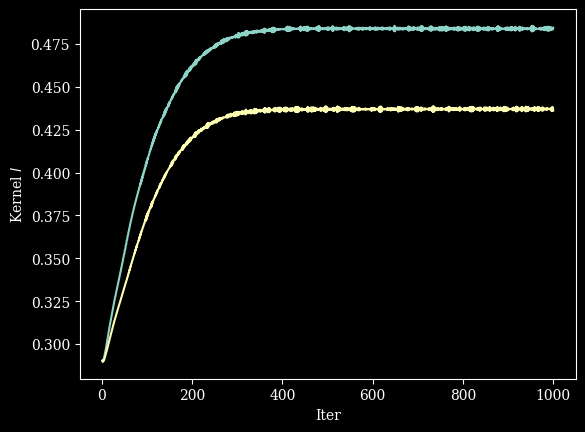

In [106]:
plt.plot(np.linspace(1, 1000, 1000), lengthscales_all,
         label="l_HF")

plt.plot(np.linspace(1, 1000, 1000), lengthscales_lf,
         label="l_LF")
plt.xlabel("Iter")
plt.ylabel("Kernel " + r"$l$")

In [107]:
np.array(adj_grads).shape, np.array(adj_grads_lf).shape

((1000, 512, 2), (1000, 512, 2))

Should correlations be computed between:

1. Raw model outputs

2. Gradient of the log probabilities OR

3. The full gradient expression?

In [108]:
g1 = adj_grads[-1]
g2 = adj_grads_lf[-1]

# Find correlations between individual velocity components
g_u = np.stack((g1[:, 0], g2[:, 0]))
g_v = np.stack((g1[:, 1], g2[:, 1]))

# corr_u = np.cov(g1[:, 0], g2[:, 0])
# corr_v = np.cov(g1[:, 1], g2[:, 1])
# corr

cov_u = np.cov(g_u)
cov_v = np.cov(g_v)

print(cov_u)
print(cov_v)

[[ 1.13464191 -0.46894524]
 [-0.46894524  0.62243731]]
[[ 0.94470974 -0.02569438]
 [-0.02569438  0.50461773]]


In [130]:
np.array(adj_grads).shape

(1000, 512, 2)

In [110]:
np.corrcoef(g_v)

array([[ 1.        , -0.03721412],
       [-0.03721412,  1.        ]])

In [109]:
np.corrcoef(g_u)

array([[ 1.        , -0.55801376],
       [-0.55801376,  1.        ]])

Correlations may be very poor for the composed function even for highly correlated models - this is the key issue?

In [111]:
l_u = np.stack((lnpgrad_samp[:, 0], lnpgrad_samp_lf[:, 0]))
l_v = np.stack((lnpgrad_samp[:, 1], lnpgrad_samp_lf[:, 1]))

cov_lu = np.cov(l_u)
cov_lv = np.cov(l_v)

print(cov_lu)
print(cov_lv)

[[0.53816983 0.62885009]
 [0.62885009 0.77501123]]
[[2.16782199 2.15462074]
 [2.15462074 2.3291326 ]]


In [112]:
np.corrcoef(l_u), np.corrcoef(l_v)

(array([[1.        , 0.97371857],
        [0.97371857, 1.        ]]),
 array([[1.        , 0.95887483],
        [0.95887483, 1.        ]]))

In [113]:
lnpgrad_inter.shape

(512, 2, 1000)

In [133]:
n_iter = 1000
covs_all_v = np.zeros((2, 2, n_iter))
covs_all_u = np.zeros((2, 2, n_iter))
cors_all_v = np.zeros((2, 2, n_iter))
cors_all_u = np.zeros((2, 2, n_iter))

cors_gu = np.zeros((2, 2, n_iter))
cors_gv = np.zeros((2, 2, n_iter))

grads_hf = np.array(adj_grads)
grads_lf = np.array(adj_grads_lf)

for i in range(n_iter):
    l_u = np.stack((lnpgrad_inter[:, 0, i], lnpgrad_inter_lf[:, 0, i]))
    l_v = np.stack((lnpgrad_inter[:, 1, i], lnpgrad_inter_lf[:, 1, i]))
    
    g_u = np.stack((grads_hf[i, :, 0], grads_lf[i, :, 0]))
    g_v = np.stack((grads_hf[i, :, 1], grads_lf[i, :, 1]))
    
    covs_all_u[:, :, i] = np.cov(l_u)
    covs_all_v[:, :, i] = np.cov(l_v)
    
    cors_all_u[:, :, i] = np.corrcoef(l_u)
    cors_all_v[:, :, i] = np.corrcoef(l_v)
    
    cors_gu[:, :, i] = np.corrcoef(g_u)
    cors_gv[:, :, i] = np.corrcoef(g_v)

<Axes: >

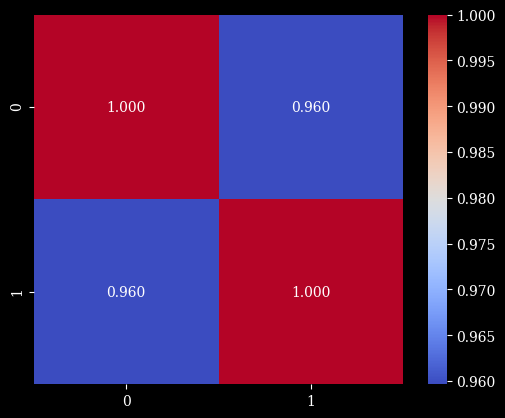

In [127]:
sns.heatmap(cors_all_v[:, :, 845],
           square=True,
           cmap='coolwarm',
           annot=True,
           fmt='.3f')

Also plot how the bifidelity correlation is changing over iterations.

Text(0.5, 1.0, 'Correlation of score over all SVGD updates')

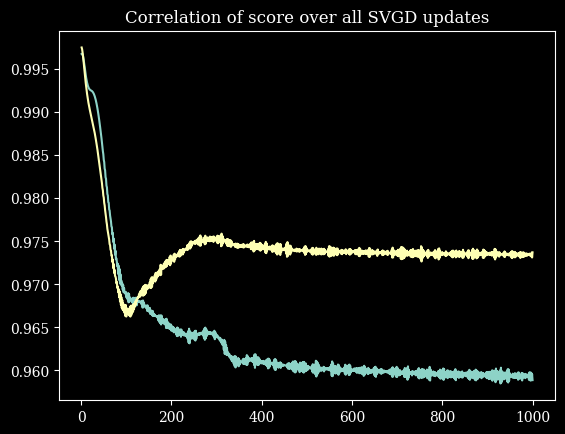

In [134]:
plt.plot(np.linspace(1, n_iter, n_iter), cors_all_v[0, 1, :])
plt.plot(np.linspace(1, n_iter, n_iter), cors_all_u[0, 1, :])
plt.title("Correlation of score over all SVGD updates")

The problematic aspect is the correlation of the gradients - though this is not revealing by itself, because the gradients are computed without any interaction between the two fidelities and don't have a lot of bearing on how well the method would work.

Text(0.5, 1.0, 'Correlation of gradients over all SVGD updates')

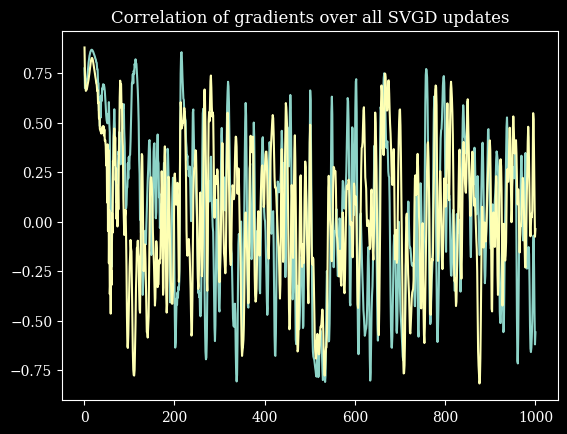

In [135]:
plt.plot(np.linspace(1, n_iter, n_iter), cors_gu[0, 1, :])
plt.plot(np.linspace(1, n_iter, n_iter), cors_gv[0, 1, :])
plt.title("Correlation of gradients over all SVGD updates")

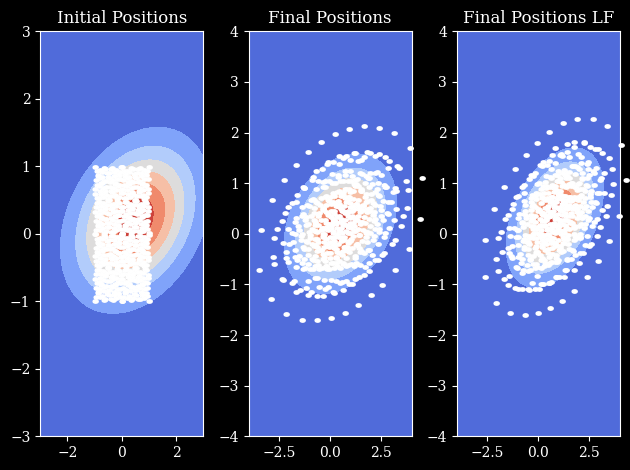

In [140]:
rv_hf = multivariate_normal(mu_oracle_hf, cov_oracle_hf)
rv_lf = multivariate_normal(mu_oracle_lf, cov_oracle_lf)


x, y = np.mgrid[-4:4:.01, -4:4:.01]
pos = np.dstack((x, y))

fig, ax = plt.subplots(1, 3)

ax[0].contourf(x, y,
             rv_hf.pdf(pos),
             cmap='coolwarm')

marker_symbol = u'\u2B2C'

# Scatter initial particles
ax[0].scatter(initial_particles[:, 0], initial_particles[:, 1],
            color="white",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False)

ax[0].set_title("Initial Positions")
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

ax[1].contourf(x, y,
             rv_hf.pdf(pos),
             cmap='coolwarm')

# Scatter initial particles
ax[1].scatter(post_particles_all[:, 0, -1], post_particles_all[:, 1, -1],
            color="white",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False)
ax[1].set_title("Final Positions")
ax[1].set_xlim(-4, 4)
ax[1].set_ylim(-4, 4)

ax[2].contourf(x, y,
             rv_lf.pdf(pos),
             cmap='coolwarm')

# Scatter initial particles
ax[2].scatter(post_particles_lf[:, 0, -1], post_particles_lf[:, 1, -1],
            color="white",
            marker="$%s$" % marker_symbol,
            s=15,
            clip_on=False)
ax[2].set_title("Final Positions LF")
ax[2].set_xlim(-4, 4)
ax[2].set_ylim(-4, 4)

fig.tight_layout()

512


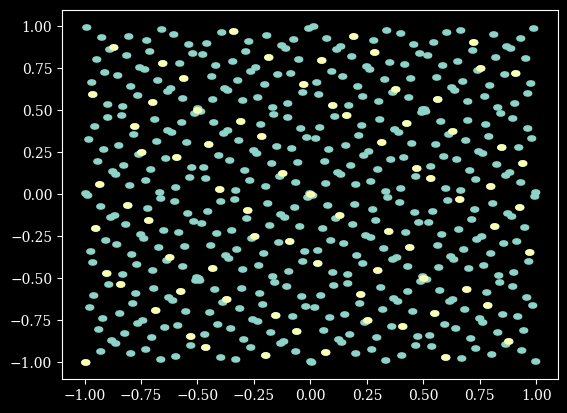

In [141]:
optimizer = Optimizer(costs, cov_lv)
result = optimizer.optimize(algorithm="acvmf", target_cost=204)
allocation = result.allocation
print(allocation.num_total_samples)
model_input_samples = allocation.allocate_samples_to_models(initial_particles)
hf_alloc = model_input_samples[0]
lf_alloc = model_input_samples[1]

plt.scatter(lf_alloc[:, 0], lf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           label="LF")

plt.scatter(hf_alloc[:, 0], hf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           label="HF")

In [63]:
optimizer = Optimizer(costs, cov_lv)
result = optimizer.optimize(algorithm="acvmf", target_cost=204)
allocation = result.allocation
print(allocation.num_total_samples)
model_input_samples = allocation.allocate_samples_to_models(initial_particles)
hf_alloc = model_input_samples[0]
lf_alloc = model_input_samples[1]

plt.scatter(lf_alloc[:, 0], lf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           label="LF")

plt.scatter(hf_alloc[:, 0], hf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           label="HF")

In [64]:
result.variance

array(0.00622144)

Assume we also initialize a separate pilot set of particles to compute a covariance matrix for one component of score function across all iterations of the SVGD method. These matrices will be used to compute stepwise sample allocations and optimal MF estimator at every step with the final larger particle set.

In [136]:
sampler2 = qmc.Sobol(d=2, scramble=False)
initial_particles2 = sampler.random(n=16)

# rescale initial points to lie within -1, 1
initial_particles2 = 2 * initial_particles2 - 1

In [137]:
pp_init_hf, ls_init_hf, kxy_samp_init_hf, dxkxy_samp_init_hf, lnpgrad_samp_init_hf, adj_grads_init_hf, lnp_init_hf = SVGD_ll().update(initial_particles2,
                                                        mvn_dlnprob_hf,
                                                        mu_oracle_hf,
                                                        cov_oracle_hf,
                                                        n_iter=1000,
                                                        stepsize=0.01,
                                                        return_all=True)

pp_init_lf, ls_init_lf, kxy_samp_init_lf, dxkxy_samp_init_lf, lnpgrad_samp_init_lf, adj_grads_init_lf, lnp_init_lf = SVGD_ll().update(initial_particles2,
                                                        mvn_dlnprob_lf,
                                                        mu_oracle_lf,
                                                        cov_oracle_lf,
                                                        n_iter=1000,
                                                        stepsize=0.01,
                                                        return_all=True)

Output()

Output()

We need to upgrade the below snippet to calculate correlations for the product of $k$ and $\nabla \log p$

In [138]:
n_iter = 1000
covs_vinit = np.zeros((2, 2, n_iter))
covs_uinit = np.zeros((2, 2, n_iter))
cors_vinit = np.zeros((2, 2, n_iter))
cors_uinit = np.zeros((2, 2, n_iter))

for i in range(n_iter):
    l_u = np.stack((lnp_init_hf[:, 0, i], lnp_init_lf[:, 0, i]))
    l_v = np.stack((lnp_init_hf[:, 1, i], lnp_init_lf[:, 1, i]))
        
    covs_uinit[:, :, i] = np.cov(l_u)
    covs_vinit[:, :, i] = np.cov(l_v)
    
    cors_uinit[:, :, i] = np.corrcoef(l_u)
    cors_vinit[:, :, i] = np.corrcoef(l_v)

We can recompute the correlations over 16 pilot particles instead of the original 512

Text(0.5, 1.0, 'Correlation of PILOT score over all SVGD updates')

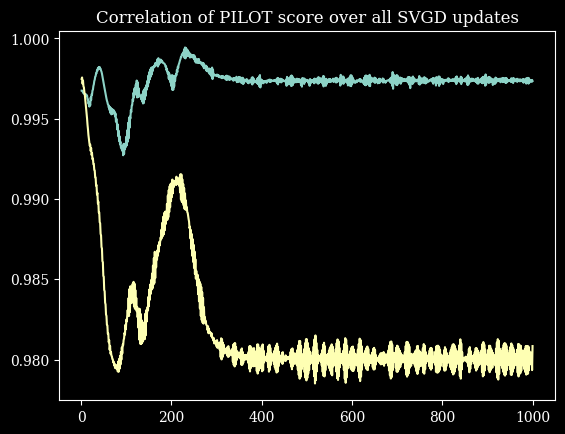

In [139]:
plt.plot(np.linspace(1, n_iter, n_iter), cors_vinit[0, 1, :])
plt.plot(np.linspace(1, n_iter, n_iter), cors_uinit[0, 1, :])
plt.title("Correlation of PILOT score over all SVGD updates")

173


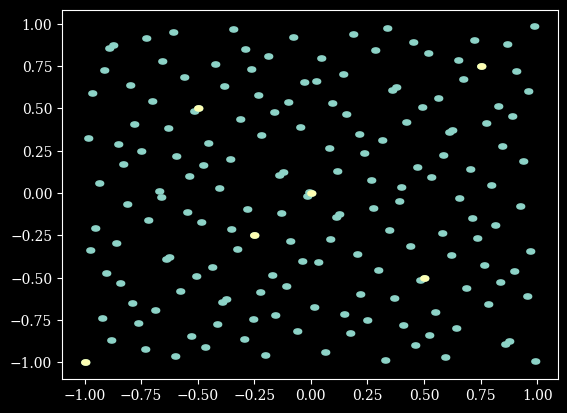

In [152]:
optimizer = Optimizer(costs, covs_vinit[:, :, 120])
result = optimizer.optimize(algorithm="acvmf", target_cost=50)
allocation = result.allocation
print(allocation.num_total_samples)
model_input_samples = allocation.allocate_samples_to_models(initial_particles)
hf_alloc = model_input_samples[0]
lf_alloc = model_input_samples[1]

plt.scatter(lf_alloc[:, 0], lf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           label="LF")

plt.scatter(hf_alloc[:, 0], hf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           label="HF")

176


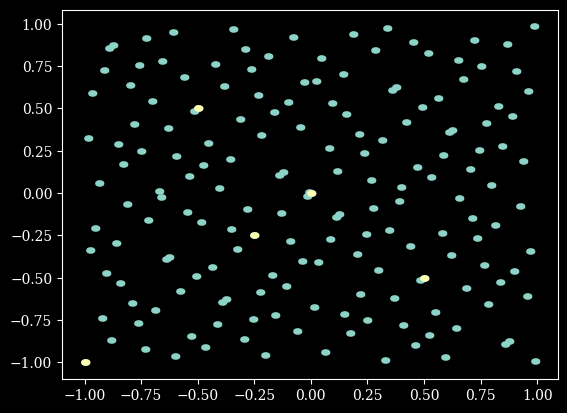

In [153]:
optimizer = Optimizer(costs, covs_vinit[:, :, 200])
result = optimizer.optimize(algorithm="acvmf", target_cost=50)
allocation = result.allocation
print(allocation.num_total_samples)
model_input_samples = allocation.allocate_samples_to_models(initial_particles)
hf_alloc = model_input_samples[0]
lf_alloc = model_input_samples[1]

plt.scatter(lf_alloc[:, 0], lf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           label="LF")

plt.scatter(hf_alloc[:, 0], hf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           label="HF")

175


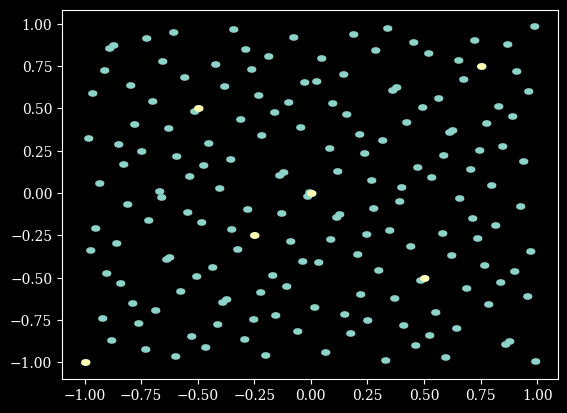

In [154]:
optimizer = Optimizer(costs, covs_vinit[:, :, 600])
result = optimizer.optimize(algorithm="acvmf", target_cost=50)
allocation = result.allocation
print(allocation.num_total_samples)
model_input_samples = allocation.allocate_samples_to_models(initial_particles)
hf_alloc = model_input_samples[0]
lf_alloc = model_input_samples[1]

plt.scatter(lf_alloc[:, 0], lf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           label="LF")

plt.scatter(hf_alloc[:, 0], hf_alloc[:, 1],
           marker="$%s$" % marker_symbol,
           label="HF")

By keeping the same target cost over every iteration, we can reallocate fidelities over an unchanged cardinality of the set of particles, using updated correlation estimates from pilot sampling.

In [ ]:
class SVGD_mf():
    """
    Slightly revised SVGD class update function. Instead of updating particle positions directly, only sample allocations
    are returned for every iteration, which are then passed to a different method to compute the final gradient estimator and necessary updates.
    """
    def __init__(self):
        pass

    def svgd_kernel(self, theta, h = -1):
        sq_dist = pdist(theta)
        pairwise_dists = squareform(sq_dist)**2
        if h < 0: # if h < 0, using median trick
            h = np.median(pairwise_dists)
            h = np.sqrt(0.5 * h / np.log(theta.shape[0]+1))

        # compute the rbf kernel
        Kxy = np.exp( -pairwise_dists / h**2 / 2)

        dxkxy = -np.matmul(Kxy, theta)
        sumkxy = np.sum(Kxy, axis=1)
        for i in range(theta.shape[1]):
            dxkxy[:, i] = dxkxy[:,i] + np.multiply(theta[:,i],sumkxy)
        dxkxy = dxkxy / (h**2)
        return (Kxy, dxkxy, h)


    def eval_grad(self, x0, lnprob, mu, cov, bandwidth=-1, alpha=0.9):
        """
        Evaluate gradient for any one fidelity, over all particles allocated to it.
        """
        theta_all = np.zeros((x0.shape[0], x0.shape[1]))
        
        
    
    
    def bf_gradients(self, x0, lnprob1,
               mu1,
               cov1,
               lnprob2,
               mu2,
               cov2,
               n_iter = 1000,
               stepsize = 1e-3,
               bandwidth = -1,
               alpha = 0.9,
               return_all = False,
               debug = False):
        # Check input
        if x0 is None or lnprob is None:
            raise ValueError('x0 or lnprob cannot be None!')

        theta_all = np.zeros((x0.shape[0], x0.shape[1], n_iter))
        lengthscales_all = np.zeros(n_iter)
        theta = np.copy(x0)

        # adagrad with momentum
        fudge_factor = 1e-6
        historical_grad = 0
        kxy_final = []
        dxkxy_final = []
        lnpgrad_final = []
        adj_grads = []
        for iter in range(n_iter):
            if debug and (iter+1) % 1000 == 0:
                print('iter ' + str(iter+1))

            lnpgrad = lnprob(theta, mu, cov)
            # calculating the kernel matrix
            kxy, dxkxy, h = self.svgd_kernel(theta, h=-1)
            grad_theta = (np.matmul(kxy, lnpgrad) + dxkxy) / x0.shape[0]

            lengthscales_all[iter] = h

            # adagrad
            if iter == 0:
                historical_grad = historical_grad + grad_theta ** 2
            else:
                historical_grad = alpha * historical_grad + (1 - alpha) * (grad_theta ** 2)
            adj_grad = np.divide(grad_theta, fudge_factor+np.sqrt(historical_grad))
            theta = theta + stepsize * adj_grad

            adj_grads.append(adj_grad)
            theta_all[:, :, iter] = theta
            if iter == n_iter - 1:
                kxy_final = kxy
                dxkxy_final = dxkxy
                lnpgrad_final = lnpgrad
        return model_gradients

In [ ]:
estimator = Estimator(allocation, cov_lv)
estimate = estimator.get_estimate(model_outputs)